### Setting up cellpose on GPU

In [2]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Thu Jul  9 00:43:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+

Install cellpose, then uninstall the CPU version, then install the GPU version

(make sure cu101 is the right CUDA version, e.g. mine is 10.1 so cu101 works, 10.0 would be cu100)

In [3]:
!pip install cellpose
!pip uninstall mxnet-mkl -y
!pip install mxnet-cu101

     |████████████████████████████████| 102kB 4.0MB/s 
     |████████████████████████████████| 76.7MB 56kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Uninstalling mxnet-mkl-1.6.0:
  Successfully uninstalled mxnet-mkl-1.6.0
     |████████████████████████████████| 710.5MB 26kB/s 


In [4]:
import mxnet as mx
from cellpose import utils
from cellpose import models

use_GPU = utils.use_gpu()
print("GPU activated? %d" % use_GPU)

GPU activated? 1


### Analysis using cellpose

In [5]:
import numpy as np
import os, sys
from skimage import io, img_as_ubyte
import matplotlib.pyplot as plt
import glob
import pandas as pd

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
sys.path.append("/content/drive/My Drive/Python_Code")
path_to_image_folder = "/content/drive/My Drive/Colab Notebooks/Current_Imaging_Analysis_Colab/PercevalHR_esgts_S3QEL2_E1F1/BacSub100/Analysis/Anterior/Cellpose_Analysis"
os.chdir(path_to_image_folder)

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Otto's python modules
from cell_counting_analysis import (
    create_img_dict_from_folder,
    save_dict_binary_masks,
    measure_region_props_to_tidy_df,
    create_labelled_img_dict_from_folder,
    num_div_denom_measure_region_props_to_tidy_df,
)
import analysing_imaging_data as aid
import custom_plotting as cp

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
C0_imgs = create_img_dict_from_folder(load_pattern="../Default_Watershed/C0/*.tiff")
C1_imgs = create_img_dict_from_folder(load_pattern="../Default_Watershed/C1/*.tiff")

In [10]:
model = models.Cellpose(gpu=use_GPU, model_type="cyto",)

Downloading: "http://www.cellpose.org/models/cyto_0" to /root/.cellpose/models/cyto_0
  0%|          | 0.00/25.2M [00:00<?, ?B/s]

>>>> using GPU


100%|██████████| 25.2M/25.2M [00:01<00:00, 22.8MB/s]
Downloading: "http://www.cellpose.org/models/cyto_1" to /root/.cellpose/models/cyto_1
100%|██████████| 25.2M/25.2M [00:01<00:00, 23.3MB/s]
Downloading: "http://www.cellpose.org/models/cyto_2" to /root/.cellpose/models/cyto_2
100%|██████████| 25.2M/25.2M [00:01<00:00, 22.6MB/s]
Downloading: "http://www.cellpose.org/models/cyto_3" to /root/.cellpose/models/cyto_3
100%|██████████| 25.2M/25.2M [00:01<00:00, 22.3MB/s]
Downloading: "http://www.cellpose.org/models/size_cyto_0.npy" to /root/.cellpose/models/size_cyto_0.npy
100%|██████████| 3.55k/3.55k [00:00<00:00, 10.6MB/s]
Downloading: "http://www.cellpose.org/models/nuclei_0" to /root/.cellpose/models/nuclei_0
100%|██████████| 25.2M/25.2M [00:01<00:00, 23.4MB/s]
Downloading: "http://www.cellpose.org/models/nuclei_1" to /root/.cellpose/models/nuclei_1
100%|██████████| 25.2M/25.2M [00:01<00:00, 23.4MB/s]
Downloading: "http://www.cellpose.org/models/nuclei_2" to /root/.cellpose/models/nuclei

In [23]:
masks, flows, styles, diams = model.eval(
    list(C1_imgs.values()),
    diameter=25,
    channels=[[0, 0]] * len(C1_imgs.keys()),
    cellprob_threshold=2,
)

processing 31 image(s)


100%|██████████| 31/31 [01:10<00:00,  2.26s/it]


In [24]:
from cellpose import plot

nimg = len(list(C1_imgs.values()))
for idx in range(nimg):
    maski = masks[idx]
    flowi = flows[idx][0]

    fig = plt.figure(figsize=(18, 12))
    plot.show_segmentation(fig, list(C1_imgs.values())[idx], maski, flowi, [[0]])
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [25]:
C1_imgs_lab = dict(zip(list(C1_imgs.keys()), masks))

In [26]:
save_dict_binary_masks(C1_imgs_lab, "C1_label_imgs", method_img_type=img_as_ubyte)

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int32 to uint8 without scaling because max value 45 fits in uint8
  return convert(image, np.uint8, force_copy)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int32 to uint8 without scaling because max value 40 fits in uint8
  return convert(image, np.uint8, force_copy)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int32 to uint8 without scaling because max value 57 fits in uint8
  return convert(image, np.uint8, force_copy)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int32 to uint8 without scaling because max value 61 fits in uint8
  return convert(image, np.uint8, force_copy)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int32 to uint8 without scaling because max value 60 fits in uint8
  return convert(image, np.uint

Binary images saved at 'C1_label_imgs'


### Per cell analysis

In [ ]:
C0_imgs = create_img_dict_from_folder(load_pattern="./C0/*.tif")
C1_imgs = create_img_dict_from_folder(load_pattern="./C1/*.tif")


# generated using cellpose cytoplasm model
C1_imgs_lab = create_labelled_img_dict_from_folder(load_pattern="C1_label_imgs/*.tiff")

In [ ]:
%gui qt5

In [ ]:
import napari

view = napari.Viewer()

In [ ]:
view.layers.select_all()
view.layers.remove_selected()
key = "o1g1"
view.add_image(C0_imgs.get(key), name=key + "_C0", colormap="blue")
view.add_image(C1_imgs.get(key), name=key + "_C1", colormap="yellow")
view.add_labels(C1_imgs_lab[key], name=key + "_label")

<Labels layer 'o1g1_label' at 0x7ffe6443b350>

In [27]:
df = num_div_denom_measure_region_props_to_tidy_df(
    num_img_dict=C1_imgs,
    denom_img_dict=C0_imgs,
    label_imgs=C1_imgs_lab,
)

In [28]:
df.query("sample_id == 'c1'")

,label,area,mean_intensity_num,image_key,mean_intensity_denom,mean_intensity_num_div_denom,sample_id,gut_id
761,1,120,554.425000,c1g1,1207.675000,0.459085,c1,1
762,2,134,629.313433,c1g1,1230.805970,0.511302,c1,1
763,3,170,557.729412,c1g1,1690.788235,0.329864,c1,1
764,4,619,2651.048465,c1g1,855.285945,3.099605,c1,1
765,5,357,740.571429,c1g1,1014.591036,0.729921,c1,1
...,...,...,...,...,...,...,...,...
1058,37,504,1223.333333,c1g9,257.380952,4.753006,c1,9
1059,38,359,417.679666,c1g9,638.064067,0.654605,c1,9
1060,39,425,1597.277647,c1g9,1689.837647,0.945226,c1,9
1061,40,363,3662.264463,c1g9,733.396694,4.993566,c1,9


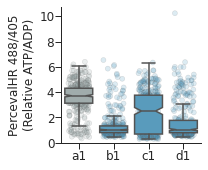

In [29]:
mypal = cp.define_pallette_tidy(df["sample_id"])
cp.tidy_create_strip_box_plot(
    x="sample_id",
    y="mean_intensity_num_div_denom",
    palette=mypal,
    x_figSize=cp.determine_fig_width_from_palette(mypal),
    data=df,
    y_label=cp.identify_y_axis_label(aid.exp_analysis_name()),
)

### Performing statistical tests on per cell data

In [ ]:
from scipy import stats
import scikit_posthocs as sp
from statsmodels import formula
from statsmodels import api
import custom_stats

In [ ]:
custom_stats.kruskal_scipy_stats_tidy_df_wrapper(
    tidy_df=df, indep_var="sample_id", dep_var="mean_intensity_num_div_denom"
)

KruskalResult(statistic=66.65101926680472, pvalue=3.2408863581511514e-16)

In [ ]:
sp.posthoc_dunn(
    df,
    val_col="mean_intensity_num_div_denom",
    group_col="sample_id",
    p_adjust="bonferroni",
)

,a1,o1
a1,-1.000000e+00,3.240886e-16
o1,3.240886e-16,-1.000000e+00


### Per gut analysis

In [ ]:
foo = aid.grouped_tidy_data_summary_stats(df, categories=df["sample_id"].unique())

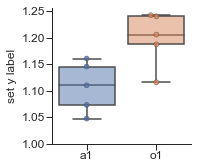

In [ ]:
cp.tidy_create_swarm_box_plot(
    x="sample_id",
    y="mean_intensity_num_div_denom",
    data=foo.query('summary_stat == "mean"'),
    y_axis_start=1,
)

### Perform statistical tests using per gut data

In [ ]:
lm = (
    formula.api.ols(
        formula="mean_intensity_num_div_denom ~ C(sample_id)",
        data=foo.query('summary_stat == "mean"'),
    )
    .fit()
)
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     mean_intensity_num_div_denom   R-squared:                       0.511
Model:                                      OLS   Adj. R-squared:                  0.450
Method:                           Least Squares   F-statistic:                     8.370
Date:                          Wed, 17 Jun 2020   Prob (F-statistic):             0.0201
Time:                                  14:29:15   Log-Likelihood:                 16.961
No. Observations:                            10   AIC:                            -29.92
Df Residuals:                                 8   BIC:                            -29.32
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.1074      0.022     49.907      0.000       1.056       1.159
C(sample_id)[T.o1]     0.0908      0.031      2.893      0.020       0.018       0.163
==============================================================================
Omnibus:                        1.139   Durbin-Watson:                   1.651
Prob(Omnibus):                  0.566   Jarque-Bera (JB):                0.867
Skew:                          -0.516   Prob(JB):                        0.648
Kurtosis:                       1.992   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
stats.ttest_ind(
    foo.query('summary_stat == "mean" & sample_id == "a1"')['mean_intensity_num_div_denom'].values,
    foo.query('summary_stat == "mean" & sample_id == "o1"')['mean_intensity_num_div_denom'].values,
)

Ttest_indResult(statistic=-2.8930373885204235, pvalue=0.02010525313059703)